# Consumer Lending Project: Lending Club

Data related source:

- https://www.lendingclub.com/info/statistics.action
- https://www.lendingclub.com/developers/listed-loans.action
- http://blog.lendingclub.com/investor-updates-and-enhancements/
- http://www.lendacademy.com/lending-club-whole-loan-program-one-year-later/

Code related source:

- https://github.com/psu4/bad-loan-prediction-lendingclub.com/blob/master/bad-loan-prediction.py#L179
- https://sites.google.com/site/2015pcsu/data-science/predicting-bad-loans-using-lendingclub-com-data
- https://rstudio-pubs-static.s3.amazonaws.com/203258_d20c1a34bc094151a0a1e4f4180c5f6f.html

## Import data

In [2]:
import pandas as pd
import numpy as np
import dateutil as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
import statsmodels.api as sm
from datetime import datetime
import warnings
import pprint
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import graphviz
import xgboost as xgb

%matplotlib inline

# In order to display all the columns, bypass the pandas autodetect
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.set_option.html
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

*All the code below is base on the principle of not changing the raw data.*

**Description of raw data:** 

- Header: specified data source: https://www.lendingclub.com/info/prospectus.action
- Footer: total amount funded in policy code 1 and 2
    - policy_code = 0: rejected
    - policy_code = 1: publicly available
    - policy_code = 2: new products not publicly available
    - currently only policy_code = 1 data open to public
- *desc* is cleared out of 2017 data
- Secondary applicants and co-borrowers information are recorded starting from 2017
- For some of the new credit attributes, we can only see history dating back to March 2012

In [3]:
loan11 = pd.read_csv('LoanStats3a_securev1.csv', header = 1, skipfooter = 2)
loan13 = pd.read_csv('LoanStats3b_securev1.csv', header = 1, skipfooter = 2)
loan14 = pd.read_csv('LoanStats3c_securev1.csv', header = 1, skipfooter = 2)
loan15 = pd.read_csv('LoanStats3d_securev1.csv', header = 1, skipfooter = 2)
loan16q1 = pd.read_csv('LoanStats_securev1_2016Q1.csv', header = 1, skipfooter = 2)
loan16q2 = pd.read_csv('LoanStats_securev1_2016Q2.csv', header = 1, skipfooter = 2)
loan16q3 = pd.read_csv('LoanStats_securev1_2016Q3.csv', header = 1, skipfooter = 2)
loan16q4 = pd.read_csv('LoanStats_securev1_2016Q4.csv', header = 1, skipfooter = 2)
loan17q1 = pd.read_csv('LoanStats_securev1_2017Q1.csv', header = 1, skipfooter = 2)
loan17q2 = pd.read_csv('LoanStats_securev1_2017Q2.csv', header = 1, skipfooter = 2)
loan17q3 = pd.read_csv('LoanStats_securev1_2017Q3.csv', header = 1, skipfooter = 2)
desc = pd.read_csv("DataDictionary.csv", encoding = "ISO-8859-1")

In [4]:
# In case
num11 = loan11.describe(include=[np.number]).T
num13 = loan13.describe(include=[np.number]).T
num14 = loan14.describe(include=[np.number]).T
num15 = loan15.describe(include=[np.number]).T
num16q1 = loan16q1.describe(include=[np.number]).T
num16q2 = loan16q2.describe(include=[np.number]).T
num16q3 = loan16q3.describe(include=[np.number]).T
num16q4 = loan16q4.describe(include=[np.number]).T
num17q1 = loan17q1.describe(include=[np.number]).T
num17q2 = loan17q2.describe(include=[np.number]).T
num17q3 = loan17q3.describe(include=[np.number]).T

cat11 = loan11.describe(include=["O"]).T
cat13 = loan13.describe(include=["O"]).T
cat14 = loan14.describe(include=["O"]).T
cat15 = loan15.describe(include=["O"]).T
cat16q1 = loan16q1.describe(include=["O"]).T
cat16q2 = loan16q2.describe(include=["O"]).T
cat16q3 = loan16q3.describe(include=["O"]).T
cat16q4 = loan16q4.describe(include=["O"]).T
cat17q1 = loan17q1.describe(include=["O"]).T
cat17q2 = loan17q2.describe(include=["O"]).T
cat17q3 = loan17q3.describe(include=["O"]).T

## Combine data

*pandas.concat* takes a list or dict of homogeneously-typed objects and concatenates them with some configurable handling of “what to do with the other axes”:

- ignore_index : boolean, default False. If True, do not use the index values on the concatenation axis. The resulting axis will be labeled 0, …, n - 1. This is useful if you are concatenating objects where the concatenation axis does not have meaningful indexing information. Note the index values on the other axes are still respected in the join.

In [5]:
Series = [loan11, loan13, loan14, loan15, loan16q1, loan16q2, loan16q3, loan16q4, loan17q1]
fullData = pd.concat(Series, ignore_index = True)
# fullData.to_csv("full.csv")

num_full = fullData.describe(include=[np.number]).T
num_full = num_full[num_full["count"] <= len(fullData)]
num_full["MissingRate"] = 100 - num_full["count"]*100/len(fullData)

cat_full = fullData.describe(include=["O"]).T
cat_full = cat_full[cat_full["count"] <= len(fullData)]
cat_full["MissingRate"] = 100 - cat_full["count"]*100/len(fullData)

In this project delete some new feature about about **secondary applicants**, **co-borrowers** and **hardship**.

**Hardship Plan**: Under the plan, borrowers are allowed to temporarily make interest-only payments for a period of 3 months to accommodate an unexpected life event. After 3 months, regular payment terms and obligations resume.

In [6]:
droplist = pd.Series(["sec_app_earliest_cr_line",    # co borrower
                      "sec_app_mths_since_last_major_derog",
                      "sec_app_revol_util",
                      "sec_app_chargeoff_within_12_mths",
                      "sec_app_fico_range_low",
                      "sec_app_fico_range_high",
                      "sec_app_inq_last_6mths",
                      "sec_app_mort_acc",
                      "sec_app_open_acc",
                      "sec_app_open_act_il",
                      "sec_app_num_rev_accts",
                      "sec_app_collections_12_mths_ex_med",
                      "revol_bal_joint",
                      "verification_status_joint",
                      "annual_inc_joint",
                      "dti_joint",                          
                      "payment_plan_start_date",     # hardship
                      "hardship_type", 
                      "hardship_reason", 
                      "hardship_start_date", 
                      "hardship_end_date", 
                      "hardship_status",
                      "hardship_loan_status",
                      "orig_projected_additional_accrued_interest",
                      "deferral_term", 
                      "hardship_amount",
                      "hardship_length",
                      "hardship_dpd", 
                      "hardship_payoff_balance_amount",
                      "hardship_last_payment_amount",    
                      "hardship_flag",
                      "debt_settlement_flag_date",    # settlement company
                      "settlement_status", 
                      "settlement_date",
                      "settlement_amount",
                      "settlement_percentage",
                      "settlement_term",
                      "debt_settlement_flag"])

fullData = fullData.drop(droplist, 1)

In this project I only use **completed** (Fully Paid or Charged Off) loans. I saved current paying loans as archive.

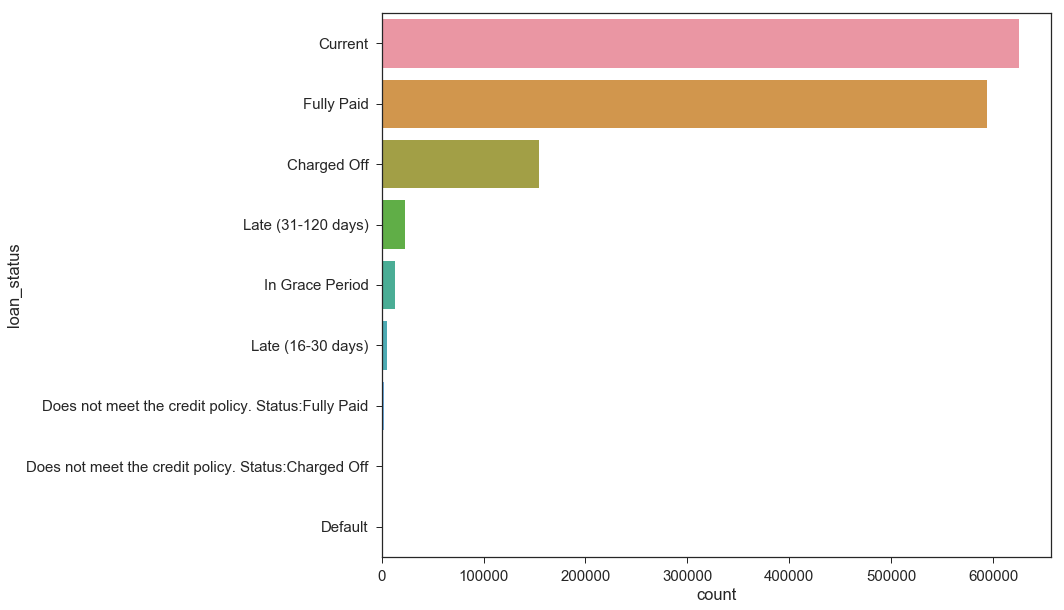

In [7]:
f, ax = plt.subplots(figsize = (12, 10))
sns.countplot(y = "loan_status", data = fullData, order = fullData["loan_status"].value_counts().index);

In [169]:
Completed = fullData[fullData['loan_status'].isin(["Fully Paid", "Charged Off"])].copy()
Current = fullData[-fullData['loan_status'].isin(["Fully Paid", "Charged Off"])].copy()

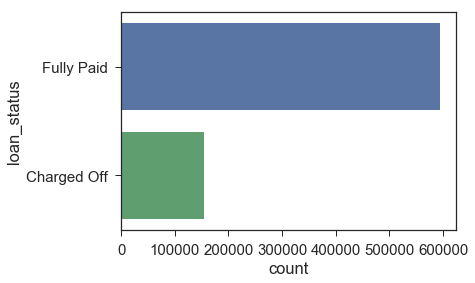

In [9]:
sns.countplot(y = "loan_status", data = Completed, order = Completed["loan_status"].value_counts().index);

In [10]:
pd.Series({"loan11" : len(loan11),
           "loan13" : len(loan13),
           "loan14" : len(loan14),
           "loan15" : len(loan15),
           "loan16q1" : len(loan16q1),
           "loan16q2" : len(loan16q2),
           "loan16q3" : len(loan16q3),
           "loan16q4" : len(loan16q4),
           "loan17q1" : len(loan17q1),
           "loan17q2" : len(loan17q2),
           "loan17q3" : len(loan17q3),
           "[Current]" : len(Current),
           "[Completed]" : len(Completed)
          })

[Completed]    748409
[Current]      670218
loan11          42536
loan13         188181
loan14         235629
loan15         421095
loan16q1       133887
loan16q2        97854
loan16q3        99120
loan16q4       103546
loan17q1        96779
loan17q2       105451
loan17q3       122701
dtype: int64

In [170]:
num = Completed.describe(include=[np.number]).T
num = num[num["count"] <= len(Completed)]
num["MissingRate"] = 100 - num["count"]*100/len(Completed)

cat = Completed.describe(include=["O"]).T
cat = cat[cat["count"] <= len(Completed)]
cat["MissingRate"] = 100 - cat["count"]*100/len(Completed)

In [171]:
cat.sort_values(["MissingRate"], ascending = 0)

,count,unique,top,freq,MissingRate
next_pymnt_d,0,0,NaN,NaN,100
desc,119228,117839,,230,84.0691
emp_title,704274,266610,Teacher,10088,5.89718
title,741543,60108,Debt consolidation,334608,0.917413
last_pymnt_d,747124,119,Mar-2017,32795,0.171698
revol_util,747962,1311,0%,3677,0.0597267
last_credit_pull_d,748372,124,Oct-2017,283851,0.00494382
purpose,748409,14,debt_consolidation,443162,0
application_type,748409,2,Individual,745995,0
initial_list_status,748409,2,f,391047,0


In [172]:
num.sort_values(["MissingRate"], ascending = 0)

,count,mean,std,min,25%,50%,75%,max,MissingRate
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
il_util,120547.0,73.139738,21.893424,0.000000e+00,61.00,76.00,88.00,2.910000e+02,83.892898
mths_since_last_record,121087.0,71.496478,27.352943,0.000000e+00,53.00,72.00,93.00,1.290000e+02,83.820745
mths_since_rcnt_il,134666.0,18.160018,23.770356,0.000000e+00,6.00,11.00,20.00,4.150000e+02,82.006363
all_util,137665.0,59.443134,20.598383,0.000000e+00,46.00,61.00,74.00,1.980000e+02,81.605646
open_acc_6m,137671.0,1.161131,1.282081,0.000000e+00,0.00,1.00,2.00,1.700000e+01,81.604844
inq_last_12m,137671.0,2.512323,2.667623,0.000000e+00,1.00,2.00,4.00,4.000000e+01,81.604844
total_cu_tl,137671.0,1.751720,2.978339,0.000000e+00,0.00,0.00,2.00,5.100000e+01,81.604844
inq_fi,137672.0,1.135278,1.642414,0.000000e+00,0.00,1.00,2.00,2.800000e+01,81.604711
max_bal_bc,137672.0,5573.422817,5715.290145,0.000000e+00,2195.00,4206.00,7229.00,7.768430e+05,81.604711


## Exploratory Analysis

Only to features that displayed on website.

**Loan Info**
- funded_amnt: The total amount committed to that loan at that point in time.
- sub_grade: LC assigned loan subgrade.
- term: The number of payments on the loan. Values are in months and can be either 36 or 60.
-----------------------------
- purpose: A category provided by the borrower for the loan request. 
- int_rate: Interest Rate on the loan.

**Borrower Info**
- home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER.
- emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- annual_inc: The self-reported annual income provided by the borrower during registration.
- dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
-----------------------------
- emp_title: The job title supplied by the Borrower when applying for the loan.
- zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application.

**Credit Info**
- fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to.
- fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to.
- earliest_cr_line: The month the borrower's earliest reported credit line was opened.
- open_acc: The number of open credit lines in the borrower's credit file.
- total_acc: The total number of credit lines currently in the borrower's credit file.
- revol_bal: Total credit revolving balance.
- revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries).
- acc_now_delinq: The number of accounts on which the borrower is now delinquent.
- delinq_amnt: The past-due amount owed for the accounts on which the borrower is now delinquent.
- delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
- mths_since_last_delinq	The number of months since the borrower's last delinquency.
- pub_rec: Number of derogatory public records.
- mths_since_last_record: The number of months since the last public record.
- mths_since_last_major_derog: Months since most recent 90-day or worse rating.
- collections_12_mths_ex_med: Number of collections in 12 months excluding medical collections.

In [295]:
variable = ["funded_amnt",
            "grade",
            "term",
            "home_ownership",
            "emp_length",
            "annual_inc",
            "dti",
            "fico_range_low",
            "fico_range_high",
            "earliest_cr_line",
            "open_acc",
            "total_acc",
            "revol_bal",
            "revol_util",
            "inq_last_6mths",
            "acc_now_delinq",
            "delinq_amnt",
            "delinq_2yrs",
            "mths_since_last_delinq",
            "pub_rec",
            "mths_since_last_record",
            "mths_since_last_major_derog",
            "collections_12_mths_ex_med",
            "loan_status"]

### Sub Grade

In [ ]:
Completed.head

In [103]:
agg = Completed.groupby(["sub_grade", "loan_status"]).size()
agg = (agg / agg.groupby(level = 0).sum()).reset_index(level = ["sub_grade", "loan_status"], name = "count")
agg.head(10)

,sub_grade,loan_status,count
0,A1,Charged Off,0.033710
1,A1,Fully Paid,0.966290
2,A2,Charged Off,0.051655
3,A2,Fully Paid,0.948345
4,A3,Charged Off,0.058058
5,A3,Fully Paid,0.941942
6,A4,Charged Off,0.072323
7,A4,Fully Paid,0.927677
8,A5,Charged Off,0.089569
9,A5,Fully Paid,0.910431


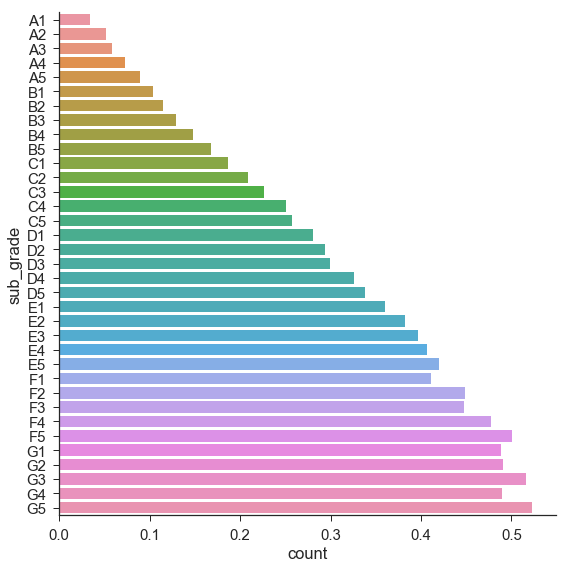

In [118]:
co = agg[agg["loan_status"] == "Charged Off"]
sns.factorplot(y = "sub_grade", x = "count", data = co, kind = "bar", size = 8)

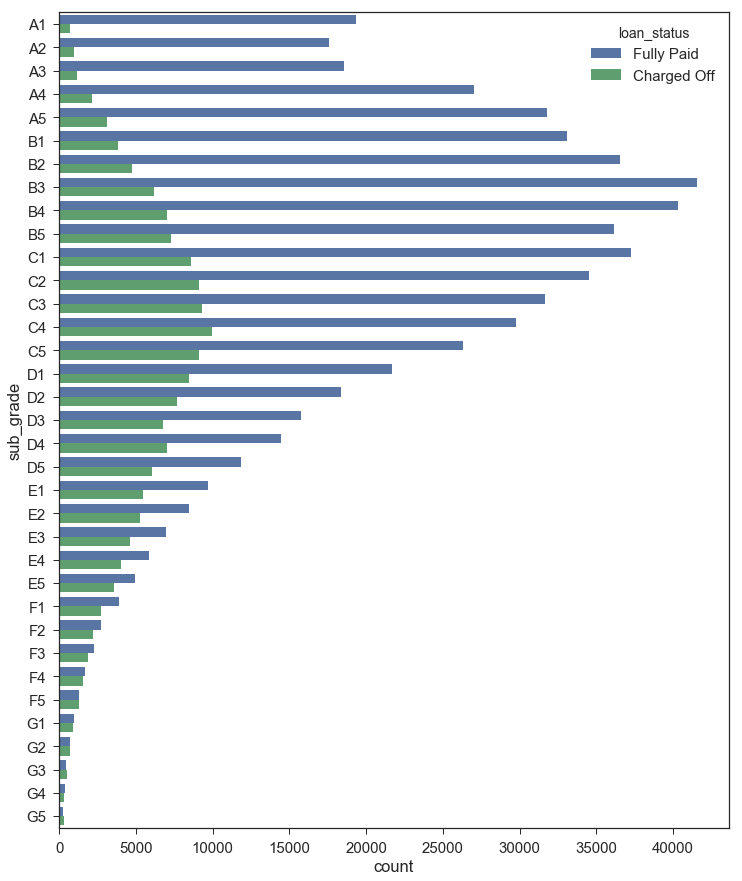

In [116]:
f, ax = plt.subplots(figsize = (12, 15))
sns.countplot(y = "sub_grade", hue = "loan_status", data = Completed, order = sorted(Completed["sub_grade"].unique()))

### Home Ownership

*Mortgage* has the least default rate.

home_ownership  loan_status
ANY             Charged Off         9
                Fully Paid         66
MORTGAGE        Charged Off     66376
                Fully Paid     307270
NONE            Charged Off         7
                Fully Paid         36
OTHER           Charged Off        27
                Fully Paid        116
OWN             Charged Off     16227
                Fully Paid      58819
RENT            Charged Off     71513
                Fully Paid     227943
dtype: int64
   home_ownership  loan_status     count
0             ANY  Charged Off  0.120000
1             ANY   Fully Paid  0.880000
2        MORTGAGE  Charged Off  0.177644
3        MORTGAGE   Fully Paid  0.822356
4            NONE  Charged Off  0.162791
5            NONE   Fully Paid  0.837209
6           OTHER  Charged Off  0.188811
7           OTHER   Fully Paid  0.811189
8             OWN  Charged Off  0.216227
9             OWN   Fully Paid  0.783773
10           RENT  Charged Off  0.238810
11         

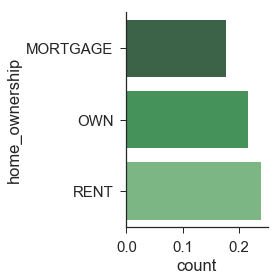

In [217]:
agg = Completed.groupby(["home_ownership", "loan_status"]).size()
print(agg)
agg_percent = (agg / agg.groupby(level = 0).sum()).reset_index(level = ["home_ownership", "loan_status"], name = "count")
print(agg_percent)
co = agg_percent[(agg_percent.loan_status == "Charged Off") &
                 ~(agg_percent.home_ownership.isin(["NONE", "OTHER", "ANY"]))]
sns.factorplot(y = "home_ownership", x = "count", data = co, kind = "bar", palette="Greens_d")

### Employment Length

*Employment length* doesn't necessary affect default rate. But *n/a* has a signaficant higher default rate.

According to LC, Null indicates not employed.

emp_length  loan_status
1 year      Charged Off     10406
            Fully Paid      38769
10+ years   Charged Off     47103
            Fully Paid     195031
2 years     Charged Off     13716
            Fully Paid      53879
3 years     Charged Off     12259
            Fully Paid      47484
4 years     Charged Off      9061
            Fully Paid      35740
5 years     Charged Off      9614
            Fully Paid      38521
6 years     Charged Off      7439
            Fully Paid      29942
7 years     Charged Off      7430
            Fully Paid      29375
8 years     Charged Off      7549
            Fully Paid      28511
9 years     Charged Off      6143
            Fully Paid      23235
< 1 year    Charged Off     12724
            Fully Paid      46602
n/a         Charged Off     10715
            Fully Paid      27161
dtype: int64


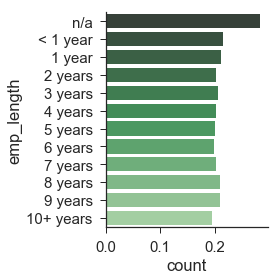

In [179]:
agg = Completed.groupby(["emp_length", "loan_status"]).size()
print(agg)
agg_percent = (agg / agg.groupby(level = 0).sum()).reset_index(level = ["emp_length", "loan_status"], name = "count")
co = agg_percent[agg_percent.loan_status == "Charged Off"]
sns.factorplot(y = "emp_length", x = "count", data = co, kind = "bar", palette="Greens_d",
               order = ["n/a", "< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years",
                       "7 years", "8 years", "9 years", "10+ years"])

Not-employed borrowers make less money.

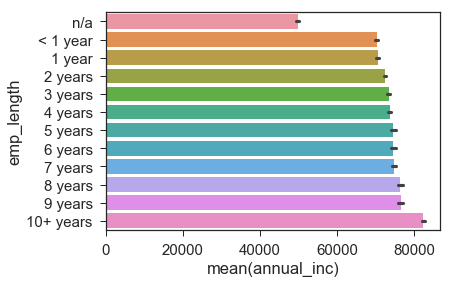

In [185]:
sns.barplot(y = "emp_length", x = "annual_inc", data = Completed,
            order = ["n/a", "< 1 year", "1 year", "2 years", "3 years", "4 years", "5 years", "6 years",
                     "7 years", "8 years", "9 years", "10+ years"])

### Annual income

No significant difference

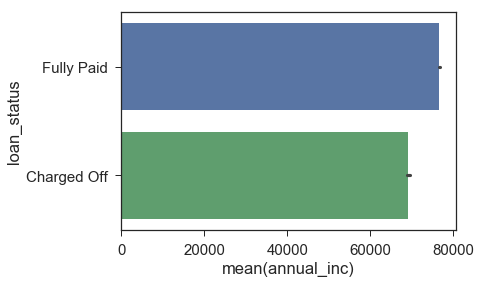

In [194]:
sns.barplot(x = "annual_inc", y = "loan_status", data = Completed)

### Debt-to-Income

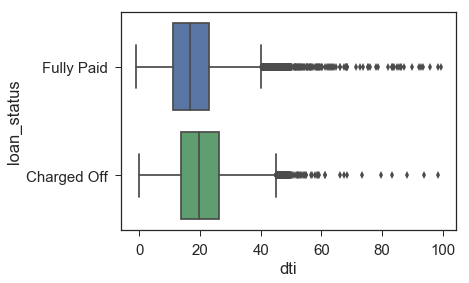

In [206]:
dti = Completed[Completed.dti <= 100]
sns.boxplot(x = "dti", y = "loan_status", data = dti)

## Data Cleaning and Manipulation

### 2007 - 2011 Loan CSV file contains 2 datasets (archive)

- Loan data: 39786 records, 14.25% were charged off
- Loans that do not meet the credit policy: 2749 records, 27.68% were charged off
    
Lending Club didn't specify what is the credit policy, but the charge-off rate is significantly higher than normal loans. I decide to delete them.

In [228]:
loan11["loan_status"].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

### Categorical variables

- Delete variables unique to each record such as **url**, **id**.
- Delete data-rich columns such as **emp_title**, **desc**, **title**, **zip_code**. Doing text mining here(later) might offer more valuable results.
- Recategorize variables with too many levels.
- Check misclassified data type such as percentage and datetime.
- Deal with columns with extreme skewness.

In [210]:
Completed["emp_length"].value_counts()

10+ years    242134
2 years       67595
3 years       59743
< 1 year      59326
1 year        49175
5 years       48135
4 years       44801
n/a           37876
6 years       37381
7 years       36805
8 years       36060
9 years       29378
Name: emp_length, dtype: int64

Employment length in months. Possible values are whole numbers from 0 and higher. Null indicates not employed.

In [211]:
Completed["emp_length"] = Completed["emp_length"].str.strip("years")
Completed["emp_length"][Completed["emp_length"]=="10+ "] = 10
Completed["emp_length"][Completed["emp_length"]=="< 1 "] = 1
Completed["emp_length"][Completed["emp_length"]=='n/'] = 0
Completed["emp_length"] = Completed["emp_length"].astype(np.int)
Completed["emp_length"].value_counts()

10    242134
1     108501
2      67595
3      59743
5      48135
4      44801
0      37876
6      37381
7      36805
8      36060
9      29378
Name: emp_length, dtype: int64

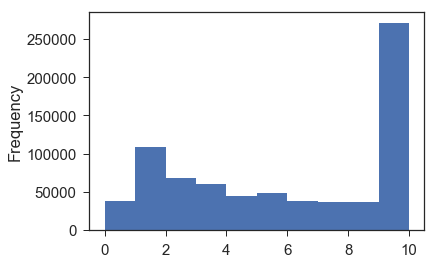

In [212]:
Completed["emp_length"].plot(kind = 'hist')

In [215]:
Completed["employment"] = "Not employed"
Completed["employment"][Completed["emp_length"] != 0] = "Employed"
Completed["employment"].value_counts()

Employed        710533
Not employed     37876
Name: employment, dtype: int64

In [216]:
Completed["home_ownership"].value_counts()

MORTGAGE    373646
RENT        299456
OWN          75046
OTHER          143
ANY             75
NONE            43
Name: home_ownership, dtype: int64

In [218]:
Completed["home_ownership"][Completed["home_ownership"].isin(["RENT", "OTHER", "NONE", "ANY"])] = "RENTorOTHER"
Completed["home_ownership"].value_counts()

MORTGAGE       373646
RENTorOTHER    299717
OWN             75046
Name: home_ownership, dtype: int64

In [219]:
Completed["verification_status"].value_counts()

Source Verified    267007
Verified           250664
Not Verified       230738
Name: verification_status, dtype: int64

In [220]:
Completed["verification_status"][Completed["verification_status"] == "Source Verified"] = "Verified"
Completed["verification_status"].value_counts()

Verified        517671
Not Verified    230738
Name: verification_status, dtype: int64

In [221]:
Completed["int_rate"] = Completed["int_rate"].str.rstrip("%").astype(np.float)
Completed["revol_util"] = Completed["revol_util"].str.rstrip("%").astype(np.float)

| LoanStatNew        | Description                                                       |
|--------------------|-------------------------------------------------------------------|
| earliest_cr_line   | The month the borrower's earliest reported credit line was opened |
| issue_d            | The month which the loan was funded                               |
| last_credit_pull_d | The most recent month LC pulled credit for this loan              |
| last_pymnt_d       | Last month payment was received                                   |
| next_pymnt_d       | Next scheduled payment date                                       |

- *pandas.to_datetime* convert argument to datetime.

- *strptime* parse a string representing a time according to a format.

- *strftime* convert a tuple or struct_time representing a time to a **string** as specified by the format argument.

In [222]:
TimeColumn = pd.Series(['issue_d', 'last_pymnt_d', 'earliest_cr_line'])

# Completed[TimeColumn] = pd.PeriodIndex(pd.to_datetime(Completed[TimeColumn]), freq='M')
Completed[TimeColumn] = Completed[TimeColumn].apply(pd.to_datetime)

# Completed["next_pymnt_d"] = pd.PeriodIndex(Completed["next_pymnt_d"], freq='M')
# Completed["last_credit_pull_d"] = pd.PeriodIndex(Completed["last_credit_pull_d"], freq='M')
Completed["earliest_cr_line"] = pd.PeriodIndex(Completed["earliest_cr_line"], freq='M')
Completed["issue_d"] = pd.PeriodIndex(Completed["issue_d"], freq='M')
Completed["last_pymnt_d"] = pd.PeriodIndex(Completed["last_pymnt_d"], freq='M')

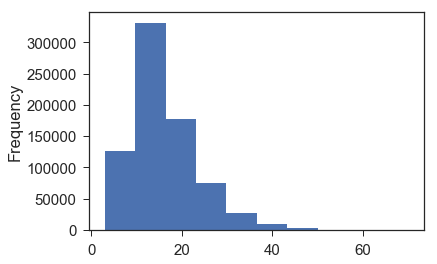

In [223]:
Completed["credit_history"] = Completed["issue_d"] - Completed["earliest_cr_line"]
Completed["credit_history"] = Completed["credit_history"].astype(np.int16)
(Completed["credit_history"]/12).plot(kind = "hist")

In [24]:
# Completed["loan_month"] = (Completed["last_pymnt_d"] - Completed["issue_d"])/ np.timedelta64(1, 'M')
# Completed["loan_month"] = (Completed["last_pymnt_d"].dt.year - Completed["issue_d"].dt.year) * 12 + 
#                          (Completed["last_pymnt_d"].dt.month - Completed["issue_d"].dt.month) + 1
# or why not just use days instead of months?
# - No, cause we are gonna compare this to "term" later, which is 36/60 month.

# Completed["loan_month"] = Completed["last_pymnt_d"] - Completed["issue_d"]
# Completed["loan_month"] = Completed["loan_month"].astype(np.int16)

In [ ]:
Completed["loan_month"].dropna().plot(kind = "hist")

In [230]:
print(Completed["pymnt_plan"].value_counts())
print("--------------------------------------------------------")
print(Completed["application_type"].value_counts())

n    748409
Name: pymnt_plan, dtype: int64
--------------------------------------------------------
Individual    745995
Joint App       2414
Name: application_type, dtype: int64


*initial_list_status*: LC announced that whole loans would be chosen randomly from the general pool, which means the variable should not effect the final status of the loan.

### Numerical variables

- Delete columns MissingRate > 5%

    <span style="color:gray">Reference: The proportion of missing data is directly related to the quality of statistical inferences. Yet, there is no established cutoff from the literature regarding an acceptable percentage of missing data in a data set for valid statistical inferences. For example, Schafer ( 1999 ) asserted that a missing rate of</span> **5%** <span style="color:gray">or less is inconsequential. Bennett ( 2001 ) maintained that statistical analysis is likely to be biased when more than</span> **10%** <span style="color:gray">of data are missing. Furthermore, the amount of missing data is not the sole criterion by which a researcher assesses the missing data problem. Tabachnick and Fidell ( 2012 ) posited that the missing data mechanisms and the missing data patterns have greater impact on research results than does the proportion of missing data. </span>
    
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3701793/
    

- Create new variables.
- Deal with columns with too much missing data.
- Deal with columns with extreme skewness.

*DataFrame.dropna* return object with labels on given axis omitted where alternately any or all of the data are missing:

- thresh: keeps only rows/columns with at least *thresh* non-na values.

- how : 
    - any : if any NA values are present, drop that label
    - all : if all values are NA, drop that label
    
- axis : 
    - 0 : index
    - 1 : columns
    
*numpy.setdiff1d*: find the set difference of two arrays ar1 and ar2. Return the sorted, unique values in ar1 that are not in ar2.

In [30]:
# Another function to drop NAs
# Completed = Completed.dropna(axis = 1, thresh = 0.05 * Completed.shape[0])
# np.setdiff1d(variable1, variable2)

droplist = numClean[numClean["MissingRate"] > 5].index
Completed = Completed.drop(droplist, 1)

In [31]:
numClean[numClean["MissingRate"] > 5].index

Index(['member_id', 'mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr

In [232]:
Completed["avg_fico"] = Completed[["fico_range_high", "fico_range_low"]].mean(axis = 1)

Delete *last fico range*: 

Reasonable to assume that if a loan is charged off, fico score of the borrower would go down accordingly. Thus we cannot use *last fico range* as predictor, it's like using the result to predict the result.

In [33]:
# Completed["last_fico"] = Completed[["last_fico_range_high", "last_fico_range_low"]].mean(axis = 1)
# Completed["fico_change"] = Completed["last_fico"] - Completed["avg_fico"]
Completed = Completed.drop(["fico_range_high", "fico_range_low", "last_fico_range_high", "last_fico_range_low"], 1)

### Skewness of independent variable

- Solution1: Delete columns with extreme skewness. Will try to manipulate these columns later. Maybe use dummy variables to recategorize them.
- **Solution2**: Fit in RandomForest model and filter out the unimportant variables.

In [34]:
# NOT OK! NOT OK! NOT OK! ###################################################
#                                                                           #
#  skewness = dataClean.isnull().skew()                                     #
#  skewness[skewness.index[skewness > 10]].sort_values(ascending = False)   #
#  dataClean = dataClean.drop(skewness.index[skewness > 10], 1)             #
#                                                                           #
#############################################################################

skew_desc = Completed.describe(include=[np.number]).T
skew_desc[skew_desc["75%"]==0]

# pd.pivot_table(Completed, index=["delinq_2yrs"], columns=["loan_status"], aggfunc="count", values="id").fillna(0)

,count,mean,std,min,25%,50%,75%,max
delinq_2yrs,608721.0,0.293000,0.827286,0.0,0.0,0.0,0.0,39.00
pub_rec,608721.0,0.190365,0.558042,0.0,0.0,0.0,0.0,86.00
out_prncp,608721.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
out_prncp_inv,608721.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
total_rec_late_fee,608721.0,0.888627,6.572717,0.0,0.0,0.0,0.0,367.60
recoveries,608721.0,189.895231,809.564894,0.0,0.0,0.0,0.0,39444.37
collection_recovery_fee,608721.0,28.415331,135.979167,0.0,0.0,0.0,0.0,7002.19
collections_12_mths_ex_med,608665.0,0.012332,0.123287,0.0,0.0,0.0,0.0,16.00
acc_now_delinq,608721.0,0.004574,0.072768,0.0,0.0,0.0,0.0,6.00
chargeoff_within_12_mths,608665.0,0.008175,0.102729,0.0,0.0,0.0,0.0,7.00


In [35]:
# droplist = ['delinq_2yrs', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens']
# Completed = Completed.drop(droplist, 1)

However the importance of *delinq_2yrs* and *pub_rec_bankruptcies* is negligible (shown in *Random Forest table of importance*), let's try some data transformation.

## Prepare data using in the model

In [296]:
variable.extend(["employment", "credit_history", "avg_fico"])
Model_data = Completed[variable]

In [297]:
describe_numerical = Model_data.describe(include=[np.number]).T
numClean = describe_numerical[describe_numerical["count"] <= len(Model_data)]
numClean["MissingRate"] = 100 - numClean["count"]*100/len(Model_data)
numClean.sort_values(["MissingRate"], ascending = 0)

,count,mean,std,min,25%,50%,75%,max,MissingRate
mths_since_last_record,121087.0,71.496478,27.352943,0.0,53.0,72.0,93.00,129.0,83.820745
mths_since_last_major_derog,186242.0,44.438075,22.148611,0.0,27.0,44.0,62.00,192.0,75.114944
mths_since_last_delinq,363244.0,34.547982,21.945990,0.0,16.0,31.0,51.00,192.0,51.464507
revol_util,747962.0,53.257197,24.294674,0.0,35.3,54.0,72.10,892.3,0.059727
collections_12_mths_ex_med,748353.0,0.013862,0.132358,0.0,0.0,0.0,0.00,20.0,0.007483
dti,748392.0,17.795660,8.599201,-1.0,11.6,17.3,23.54,999.0,0.002271
inq_last_6mths,748408.0,0.732087,0.997117,0.0,0.0,0.0,1.00,8.0,0.000134
delinq_amnt,748409.0,13.420268,714.192988,0.0,0.0,0.0,0.00,88216.0,0.000000
credit_history,748409.0,192.282510,87.980996,36.0,133.0,175.0,236.00,842.0,0.000000
pub_rec,748409.0,0.201421,0.579935,0.0,0.0,0.0,0.00,86.0,0.000000


In [298]:
describe_categorical = Model_data.describe(include=["O"]).T
catClean = describe_categorical[describe_categorical["count"] <= len(Model_data)]
catClean["MissingRate"] = 100 - catClean["count"]*100/len(Model_data)
catClean.sort_values(["MissingRate"], ascending = 0)

,count,unique,top,freq,MissingRate
grade,748409,7,B,216748,0
term,748409,2,36 months,568280,0
home_ownership,748409,3,MORTGAGE,373646,0
earliest_cr_line,748409,706,2001-08,5538,0
loan_status,748409,2,Fully Paid,594250,0
employment,748409,2,Employed,710533,0


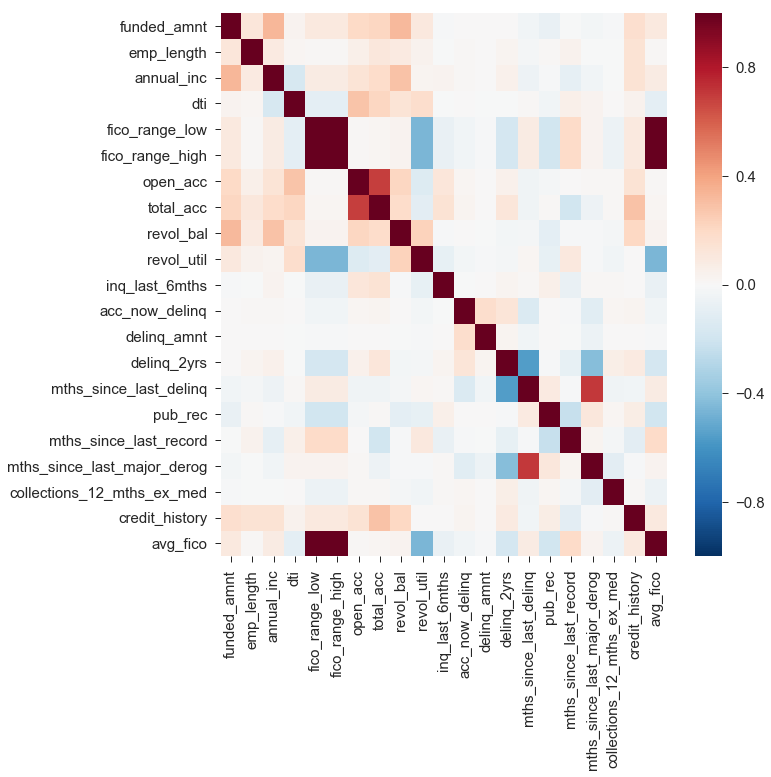

In [299]:
corr = Model_data.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# corr[list(Completed)[3]][corr[list(Completed)[3]]>0.9]
# corr["tot_cur_bal"][corr["tot_cur_bal"]>0.5]

In [300]:
droplist = pd.Series(["fico_range_high", "fico_range_low","earliest_cr_line"])
Model_data = Model_data.drop(droplist, 1)

**If a borrower has no public record, then his/her months since last public record feature will be missing.**

In [301]:
droplist = pd.Series(["mths_since_last_record", "mths_since_last_major_derog","mths_since_last_delinq"])
Model_data = Model_data.drop(droplist, 1)

In [302]:
Model_data["revol_util"] = Model_data["revol_util"].fillna(Model_data["revol_util"].mean())
Model_data["dti"] = Model_data["dti"].fillna(Model_data["dti"].mean())
Model_data["collections_12_mths_ex_med"] = Model_data["collections_12_mths_ex_med"].fillna(0)
Model_data["inq_last_6mths"] = Model_data["inq_last_6mths"].fillna(0)

### Response variable: loan_status

- 1: Loans fully paid
- 0: Loans charged off, late, in grace period
- others: Loans I'll use later for the implementation/prediction part of the model

*"Does not meet the credit policy."* only in 2015 dataset.

In [303]:
Model_data["loan_status"].value_counts()

Fully Paid     594250
Charged Off    154159
Name: loan_status, dtype: int64

### Another loan status indicator: loan_month

loan_month = Last Payment Date - Issue Date

#### Delete: loans never get paid

last_pymnt_d = NaN: 1319 loans

loan_status is one of the below. We may consider these loans as default or **drop** them cause they never get paid.

#### Question: loans longer than payment term but still paying, delete or not??

There are about 20K in 600K loans.

Although they are longer than *term*, only 121 are charged off. Do we really need to delete them?

In [42]:
longer_36 = Completed.query("term == ' 36 months' & loan_month > 36")
longer_60 = Completed.query("term == ' 60 months' & loan_month > 60")
longer = longer_36.append(longer_60)
longer["loan_status"].value_counts()

Fully Paid     20169
Charged Off      121
Name: loan_status, dtype: int64

- Fully Paid:     80529
- Current:          941
- Charged Off:      349

### Create Dummy vatiables for categorical variables

Only consider levels < 10

- term
- grade
- home_ownership

Actually XGBoost can deal with sparse matrix so I will create more dummys later.

In [305]:
term = pd.get_dummies(Model_data["term"])
grade = pd.get_dummies(Model_data["grade"])
home_ownership = pd.get_dummies(Model_data["home_ownership"])
employment = pd.get_dummies(Model_data["employment"])

In [306]:
Model_data = pd.concat([Model_data, term, grade, home_ownership, employment], axis = 1)
Model_data = Model_data.drop(["term", "grade", "home_ownership", "employment"], 1)

## Model selection

### Split 3/7 training/testing

Kept all numerical variables to run a rough model. Sklearn needs all categorical variables to be transformed into dummys.

In [307]:
positive = ['Fully Paid']
negative = ['Charged Off']

Model_data['loan_status'] = Model_data['loan_status'].isin(positive).astype(int)

In [308]:
Model_data.columns

Index(['funded_amnt', 'emp_length', 'annual_inc', 'dti', 'open_acc',
       'total_acc', 'revol_bal', 'revol_util', 'inq_last_6mths',
       'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'pub_rec',
       'collections_12_mths_ex_med', 'loan_status', 'credit_history',
       'avg_fico', ' 36 months', ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'MORTGAGE', 'OWN', 'RENTorOTHER', 'Employed', 'Not employed'],
      dtype='object')

In [316]:
cols_to_keep = ['loan_status', 'funded_amnt', 'emp_length', 'annual_inc', 'dti', 'open_acc',
                'total_acc', 'revol_bal', 'revol_util', 'inq_last_6mths',
                'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'pub_rec',
                'collections_12_mths_ex_med', 'credit_history',
                'avg_fico', ' 36 months', ' 60 months', 'A', 'B', 'C', 'D', 'E', 'F',
                'G', 'MORTGAGE', 'OWN', 'RENTorOTHER', 'Employed', 'Not employed']
ml_df = Model_data[cols_to_keep]
train_cols = ml_df.columns[1:]

In [309]:
Model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748409 entries, 0 to 1418620
Data columns (total 31 columns):
funded_amnt                   748409 non-null float64
emp_length                    748409 non-null int32
annual_inc                    748409 non-null float64
dti                           748409 non-null float64
open_acc                      748409 non-null float64
total_acc                     748409 non-null float64
revol_bal                     748409 non-null float64
revol_util                    748409 non-null float64
inq_last_6mths                748409 non-null float64
acc_now_delinq                748409 non-null float64
delinq_amnt                   748409 non-null float64
delinq_2yrs                   748409 non-null float64
pub_rec                       748409 non-null float64
collections_12_mths_ex_med    748409 non-null float64
loan_status                   748409 non-null int32
credit_history                748409 non-null int16
avg_fico                      

In [317]:
X_train, X_test, y_train, y_test = train_test_split(ml_df[train_cols], ml_df['loan_status'], test_size = 0.3, random_state = 1)

### Logistic Regression

In [318]:
logit = sm.Logit(y_train, X_train)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.461270
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:               523886
Model:                          Logit   Df Residuals:                   523859
Method:                           MLE   Df Model:                           26
Date:                Mon, 20 Nov 2017   Pseudo R-squ.:                 0.09289
Time:                        19:16:20   Log-Likelihood:            -2.4165e+05
converged:                       True   LL-Null:                   -2.6640e+05
                                        LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
funded_amnt                -1.372e-05   5.49e-07    -24.967      0.000   -1.48e-05   -1.26e-05
emp_length                     0.0054      0.001      4.917      0.000       0.003       0.008
annual_inc                  1.592e-06   1.13e-07     14.114      0.000    1.37e-06    1.81e-06
dti                           -0.0262      0.000    -52.824      0.000      -0.027      -0.025
open_acc                      -0.0253      0.001    -25.852      0.000      -0.027      -0.023
total_acc                      0.0138      0.000     30.225      0.000       0.013       0.015
revol_bal                    3.05e-06   2.61e-07     11.703      0.000    2.54e-06    3.56e-06
revol_util                     0.0005      0.000      2.436      0.015    9.06e-05       0.001
inq_last_6mths                -0.0635      0.004    -17.431      0.000      -0.071      -0.056
acc_now_delinq                 0.0108      0.045      0.239      0.811      -0.078       0.100
delinq_amnt                -6.076e-06   4.32e-06     -1.407      0.159   -1.45e-05    2.39e-06
delinq_2yrs                   -0.0316      0.004     -7.582      0.000      -0.040      -0.023
pub_rec                       -0.0183      0.006     -2.967      0.003      -0.030      -0.006
collections_12_mths_ex_med    -0.2075      0.024     -8.483      0.000      -0.255      -0.160
credit_history             -7.875e-05   4.64e-05     -1.697      0.090      -0.000    1.22e-05
avg_fico                       0.0063      0.000     36.060      0.000       0.006       0.007
 36 months                     4.3362        nan        nan        nan         nan         nan
 60 months                     3.8028        nan        nan        nan         nan         nan
A                             -4.4299   1.56e+05  -2.84e-05      1.000   -3.06e+05    3.06e+05
B                             -4.8927   1.56e+05  -3.14e-05      1.000   -3.06e+05    3.06e+05
C                             -5.3005   1.57e+05  -3.38e-05      1.000   -3.07e+05    3.07e+05
D                             -5.5705   1.57e+05  -3.54e-05      1.000   -3.08e+05    3.08e+05
E                             -5.7714   1.56e+05  -3.69e-05      1.000   -3.07e+05    3.07e+05
F                             -5.8771   1.55e+05  -3.78e-05      1.000   -3.04e+05    3.04e+05
G                             -5.9909   1.56e+05  -3.85e-05      1.000   -3.05e+05    3.05e+05
MORTGAGE                      -0.5207        nan        nan        nan         nan         nan
OWN                           -0.7093        nan        nan        nan         nan         nan
RENTorOTHER                   -0.8470        nan        nan        nan         nan         nan
Employed                      -0.8028        nan        nan        nan         nan         nan
Not employed                  -1.2742        nan        nan        nan         nan         nan
==============================================================================================
"""

In [319]:
lr_pred = result.predict(X_test)
fpr, tpr, thresholds =roc_curve(y_test, lr_pred)

#  Area Under the Curve
roc_auc = auc(fpr, tpr)

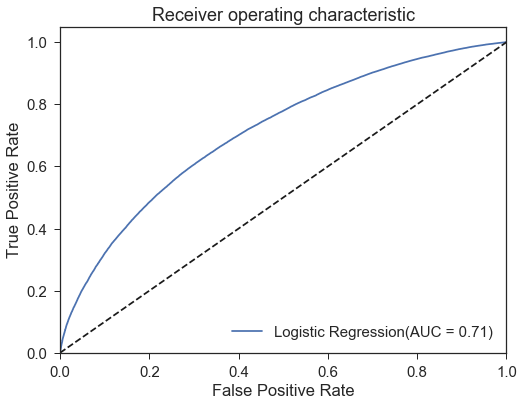

In [320]:
plt.figure(figsize = (8, 6))
plt.plot(fpr,tpr,label='Logistic Regression(AUC = %0.2f)' % roc_auc)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [321]:
rf = RandomForestClassifier()
rf_result = rf.fit(X_train, y_train)
rf_pred = rf_result.predict(X_test)
fpr2, tpr2, thresholds2 = roc_curve(y_test, rf_pred)
roc_auc2 = auc(fpr2,tpr2)

In [322]:
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index = train_cols, columns = ["Importance"])
importance.sort_values("Importance")

,Importance
acc_now_delinq,0.000937
delinq_amnt,0.001078
G,0.001305
Employed,0.001752
Not employed,0.001802
collections_12_mths_ex_med,0.003158
OWN,0.003985
F,0.004503
C,0.005013
MORTGAGE,0.005207


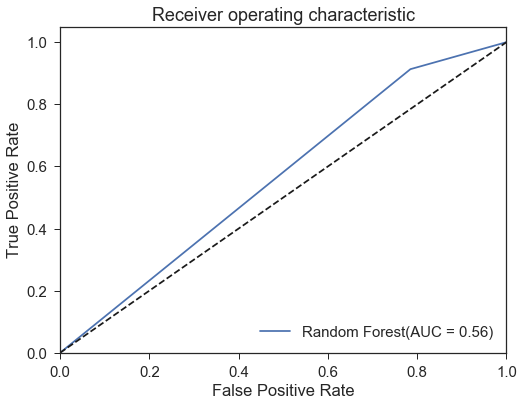

In [324]:
plt.figure(figsize = (8, 6))
plt.plot(fpr2,tpr2,label='Random Forest(AUC = %0.2f)' % roc_auc2)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### KNN

In [ ]:
# best K

k_range = range(31,50)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_result = knn.fit(X_train,y_train)
    knn_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, knn_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Performance')
plt.title('The effect of "k" in k-nearest neighbor')

In [ ]:
knn = KNeighborsClassifier()
knn_result = knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
fpr3, tpr3, thresholds3 =roc_curve(y_test, knn_pred)
roc_auc3 = auc(fpr3, tpr3)

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(fpr3,tpr3,label='kNN(AUC = %0.2f)' % roc_auc3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Linear SVM

In [326]:
clf = svm.LinearSVC(dual = False, C = 100)
clf_result = clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)
fpr4, tpr4, thresholds4 = roc_curve(y_test, clf_pred)
roc_auc4 = auc(fpr4, tpr4)

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(fpr4,tpr4,label='LinearSVM(AUC = %0.2f)' % roc_auc4)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### XGBoost

In [328]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [329]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
plst = param.items()

evallist  = [(dtest,'eval'), (dtrain,'train')]

In [330]:
num_round = 100
bst = xgb.train(plst, dtrain, num_round)

In [331]:
ypred = bst.predict(dtest)

In [332]:
fpr5, tpr5, thresholds5 = roc_curve(y_test, ypred)
roc_auc5 = auc(fpr5, tpr5)

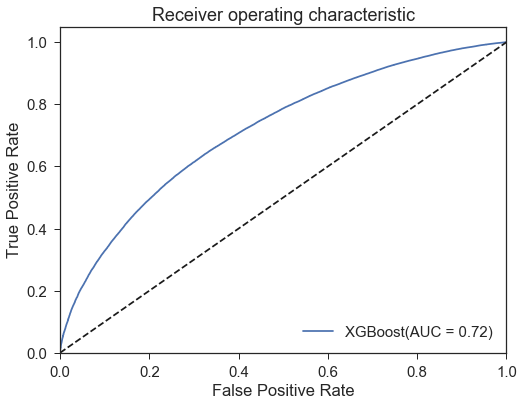

In [333]:
plt.figure(figsize = (8, 6))
plt.plot(fpr5,tpr5,label='XGBoost(AUC = %0.2f)' % roc_auc5)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

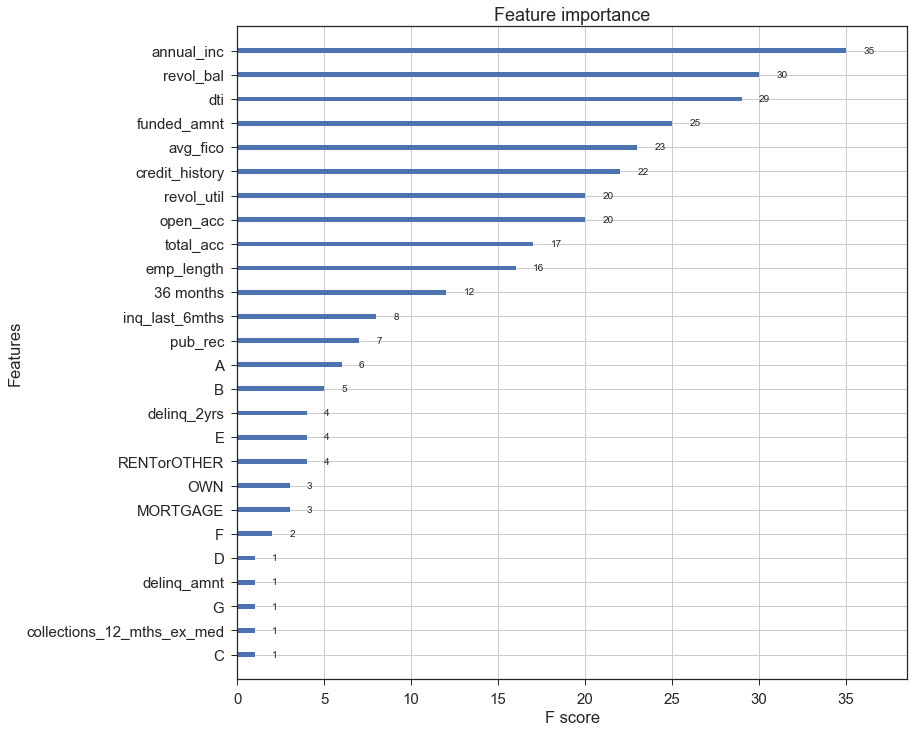

In [334]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(bst, ax = ax)

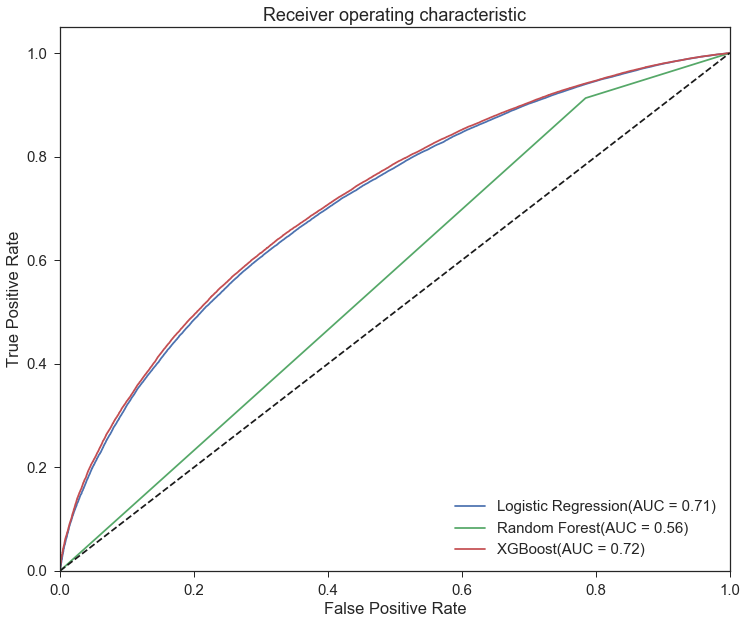

In [335]:
plt.figure(figsize = (12, 10))
plt.plot(fpr,tpr,label='Logistic Regression(AUC = %0.2f)' % roc_auc)
plt.plot(fpr2,tpr2,label='Random Forest(AUC = %0.2f)' % roc_auc2)
#plt.plot(fpr3,tpr3,label='kNN(AUC = %0.2f)' % roc_auc3)
#plt.plot(fpr4,tpr4,label='LinearSVM(AUC = %0.2f)' % roc_auc4)
plt.plot(fpr5,tpr5,label='XGBoost(AUC = %0.2f)' % roc_auc5)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()